# Data distribution

The main goal of this notebook is looking at the data distribution and it's scaling.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
#from mpl_toolkits.axes_grid.inset_locator import inset_axes

plt.rcParams["figure.dpi"] = 200
# plt.rcParams["figure.figsize"] = (20,10)
# plt.rcParams['font.size'] = 20
# plt.rcParams['axes.labelpad'] = 20
# plt.rcParams['axes.titlepad'] = 30
# plt.rcParams['xtick.minor.pad'] = 15
# plt.rcParams['xtick.major.pad'] = 15
# plt.rcParams['ytick.minor.pad'] = 15
# plt.rcParams['ytick.major.pad'] = 15
# plt.rcParams['figure.constrained_layout.use'] = False

## Manna model

0it [00:00, ?it/s]

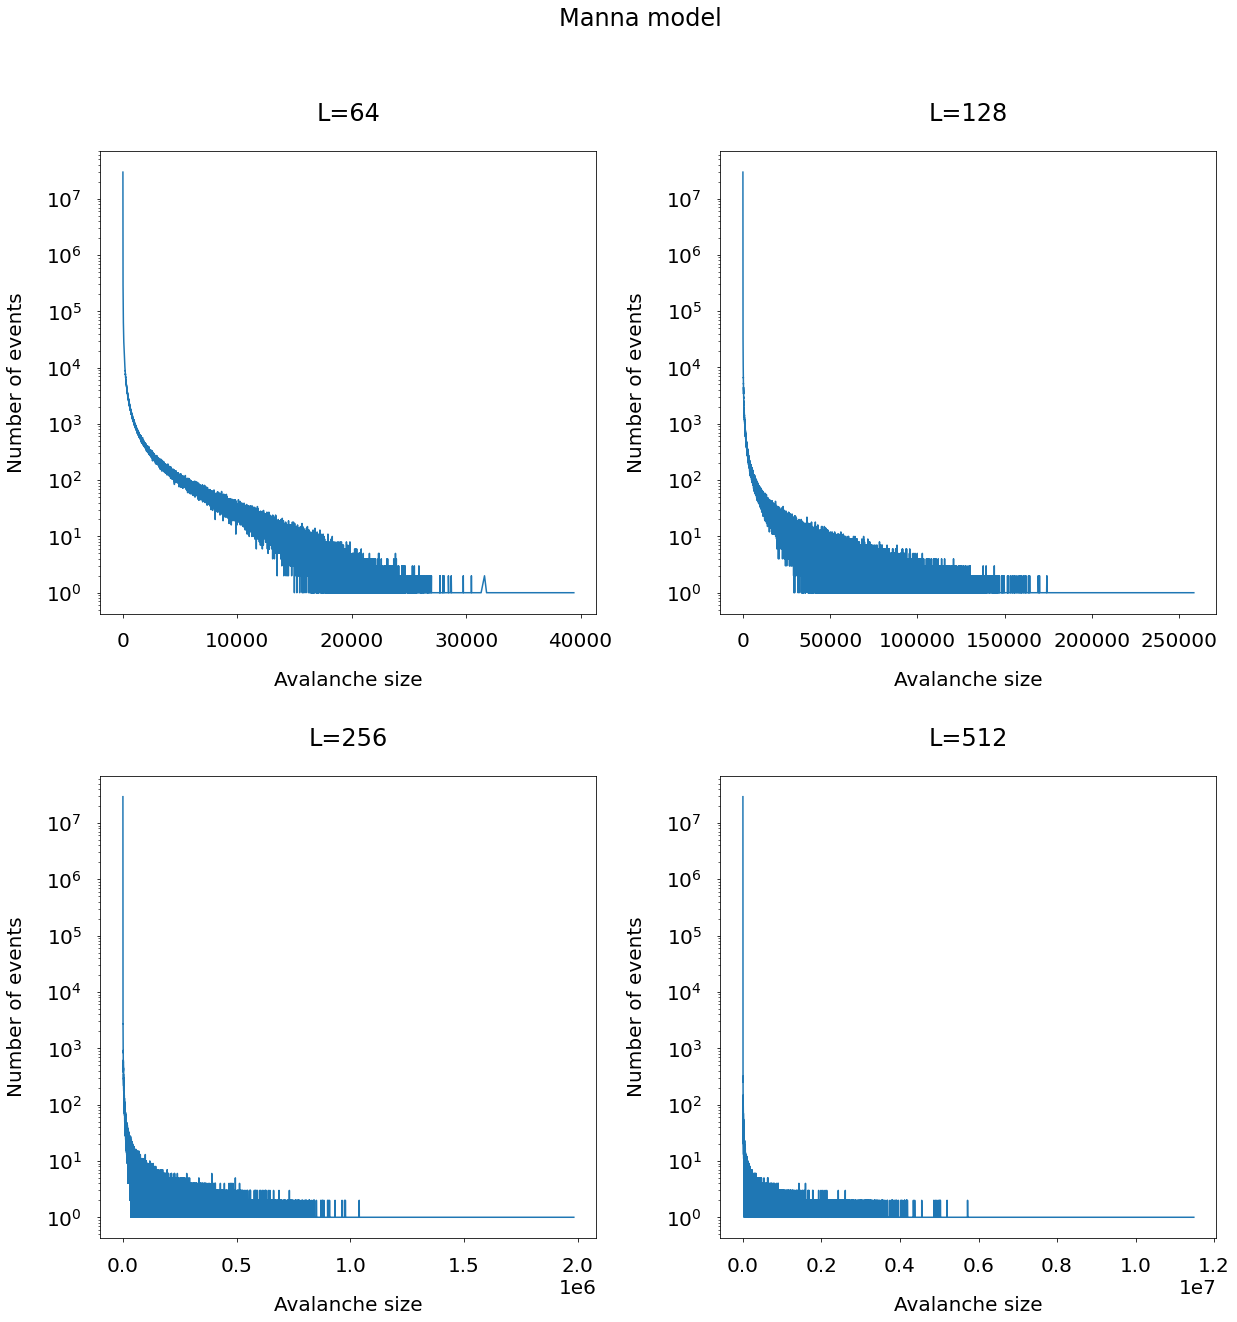

In [2]:
rand = {}

fig, _ = plt.subplots(2,2,figsize=(20,20))
fig.subplots_adjust(hspace=0.35, wspace=0.25)

for i, L in tqdm(enumerate([64, 128, 256, 512])):
    with open(f'../data/distribution/train_{L}_rand.out') as f:
        plt.subplot(2, 2, i+1)
        rand[L] = {}
        for line in f:
            size, count = list(map(int, line.split()))
            rand[L][size] = count
        plt.plot(rand[L].keys(), rand[L].values(), label=L)
        plt.yscale("log")
        plt.xlabel("Avalanche size")
        plt.ylabel("Number of events")
        plt.title(f"L={L}")

plt.suptitle("Manna model")

plt.show()

0it [00:00, ?it/s]

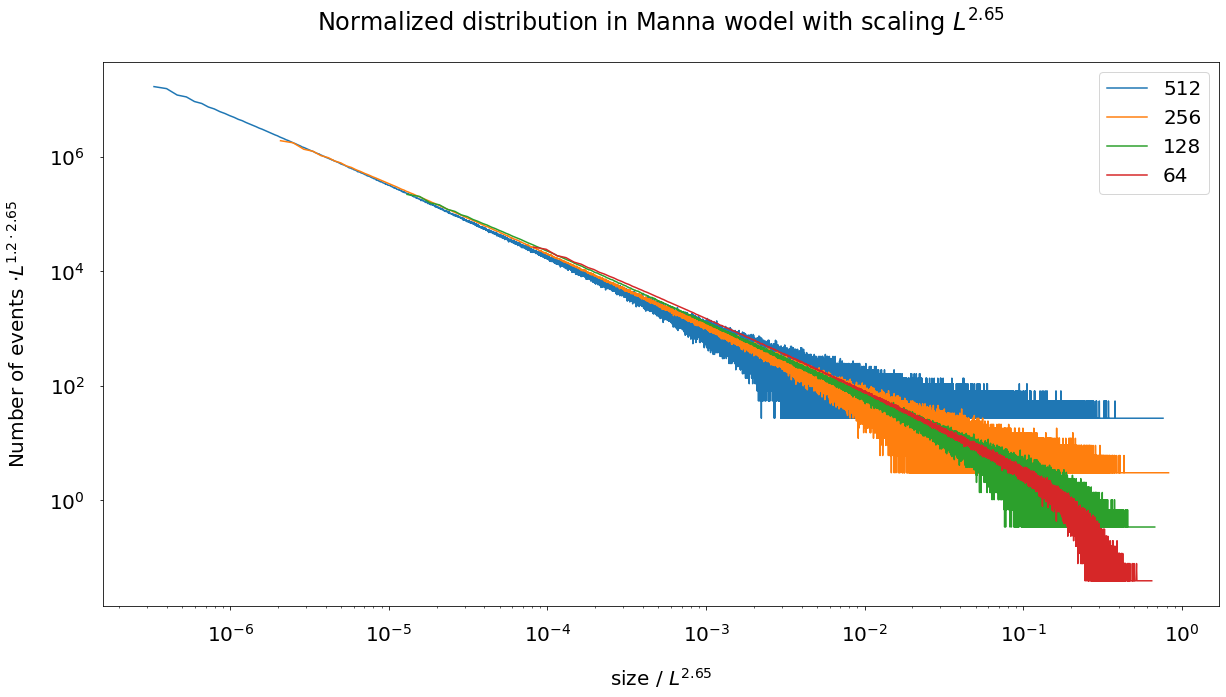

In [3]:
gamma = 2.65

for i, L in tqdm(enumerate(reversed([64, 128, 256, 512]))):
    sizes = np.array(list(rand[L].keys())[5:])
    count = np.array(list(rand[L].values())[5:])
    count = count / count.sum()
    plt.plot(sizes / L**gamma, count * L**(gamma * 1.20), label=L)
plt.title("Normalized distribution in Manna wodel with scaling $L^{" + str(gamma) + "}$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel("size / $L^{" + str(gamma) + "}$")
plt.ylabel("Number of events $\cdot L^{1.2 \cdot " + str(gamma) + "}$")
plt.show()

In [4]:
def mfr(data, smax, smin, gap=1.2):
    lgap = np.log10(gap)
    lgsmax = np.log(smax) / np.log(10)
    lgsmin = np.log(smin) / np.log(10)
    num_of_size_arr = int(np.floor((lgsmax-lgsmin)/lgap))+1 #array length
    
    x = np.array([10 ** (lgsmin + lgap*(i+0.5)) for i in range(num_of_size_arr)])
    q = [0 for _ in range(num_of_size_arr)]
    s_out_of_arr = 0
    num_of_lines = 0
    for size, count in data.items():
        if size == 0:
            s_out_of_arr += count
            continue
        ind = int(np.floor((np.log10(size) - lgsmin) / lgap))
        if ind >= 0 and ind < num_of_size_arr:
            q[ind] += count
        else:
            s_out_of_arr += count

    q_int = np.array(q)
    total_event_num = q_int.sum() + s_out_of_arr

    q_sum = sum(q)
    return x, q_int, q_sum

In [28]:
def plot_distribution(all_data, gamma=None, title=False, yscale=None, y_str = None, xlim=[1e-7, 1e+0], innerxlim=[1e-7,1e+0], innerylim=[1e-1, 1e+1]):
    fig, ax = plt.subplots(1, 1)
    
    #for i, L in tqdm(enumerate(reversed([64, 128, 256, 512]))):
    for i, L in tqdm(enumerate([64, 128, 256, 512])):    
        bins, count, total_count = mfr(all_data[L], 1e7, 5)
        count = count / total_count
        if gamma is None:
            ax.plot(bins, count, label=L)
        else:
            ax.plot(bins / L**gamma, count * L**(gamma * yscale), label=L)
    
    if gamma is not None:
        inner = inset_axes(parent_axes=ax,
                           width="65%",
                           height="50%",
                           loc=3,
                           borderpad=4)

        #for i, L in tqdm(enumerate(reversed([64, 128, 256, 512]))):
        for i, L in tqdm(enumerate([64, 128, 256, 512])):
            bins, count, total_count = mfr(all_data[L], 1e7, 5)
            count = count / total_count
            if gamma is None:
                inner.plot(bins, count, label=L)
            else:
                inner.plot(bins / L**gamma, count * L**(gamma * yscale), label=L)
                
    if gamma is None:
        if title:
            ax.set_title("Распределения событий в модели Манна")
        ax.set_xlabel("Размер события")
        ax.set_ylabel("Вероятность события")
    else:
        if title:
            ax.set_title("Отнормированное распределение событий по $L^{" + str(gamma) + "}$ в модели Манна")
        ax.set_xlabel("Размер события / $L^{" + str(gamma) + "}$")
        ax.set_ylabel("Вероятность события $\cdot L^{" + str(gamma) + r" \cdot " + y_str + "}$")
        ax.set_xlim(xlim)
        
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend(loc=1)
    
    if gamma is not None:
        inner.set_yscale("log")
        inner.set_xscale("log")
        inner.set_xlim(innerxlim)
        inner.set_ylim(innerylim)
    
    plt.show()

In [29]:
def plot_distribution_ysacle2(all_data, gamma=None, title=False, yscale=None, beta=1, y_str = None, xlim=[1e-7, 1e+0], innerxlim=[1e-7,1e+0], innerylim=[1e-1, 1e+1]):
    fig, ax = plt.subplots(1, 1)
    
    #for i, L in tqdm(enumerate(reversed([64, 128, 256, 512]))):
    for i, L in tqdm(enumerate([64, 128, 256, 512])): 
        bins, count, total_count = mfr(all_data[L], 1e7, 5)
        count = count / total_count
        if gamma is None:
            ax.plot(bins, count, label=L)
        else:
            ax.plot(bins / L**gamma, count * L**(gamma * yscale) * (bins / L**gamma)**beta, label=L)
    
    if gamma is not None:
        inner = inset_axes(parent_axes=ax,
                           width="65%",
                           height="50%",
                           loc=3,
                           borderpad=4)

        #for i, L in tqdm(enumerate(reversed([64, 128, 256, 512]))):
        for i, L in tqdm(enumerate([64, 128, 256, 512])):
            bins, count, total_count = mfr(all_data[L], 1e7, 5)
            count = count / total_count
            if gamma is None:
                inner.plot(bins, count, label=L)
            else:
                inner.plot(bins / L**gamma, count * L**(gamma * yscale) * (bins / L**gamma)**beta, label=L)
                
    if gamma is None:
        if title:
            ax.set_title("Распределения событий в модели Манна")
        ax.set_xlabel("Размер события")
        ax.set_ylabel("Вероятность события")
    else:
        if title:
            ax.set_title("Отнормированное распределение событий по $L^{" + str(gamma) + "}$ в модели Манна")
        ax.set_xlabel("Размер события / $L^{" + str(gamma) + "}$")
        ax.set_ylabel("Вероятность события $\cdot L^{" + str(gamma) + r" \cdot " + y_str + "} \cdot s$")
        ax.set_xlim(xlim)
        
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend(loc=1)
    
    if gamma is not None:
        inner.set_yscale("log")
        inner.set_xscale("log")
        inner.set_xlim(innerxlim)
        inner.set_ylim(innerylim)
    
    plt.show()

0it [00:00, ?it/s]

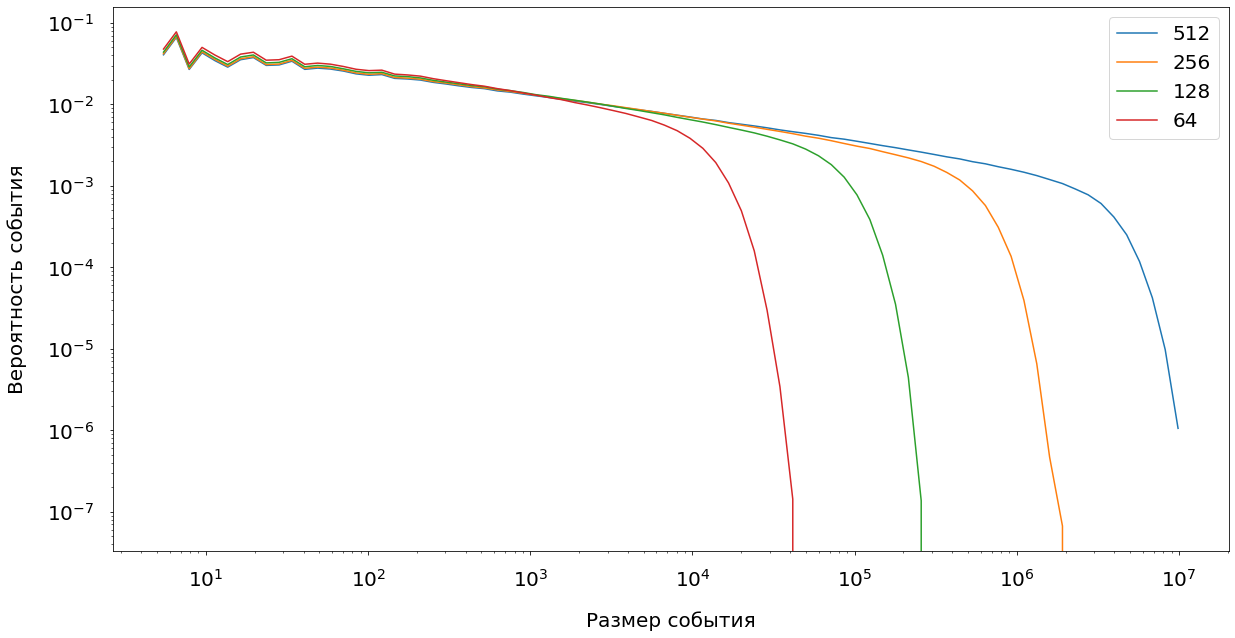

In [6]:
plot_distribution(rand, None)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

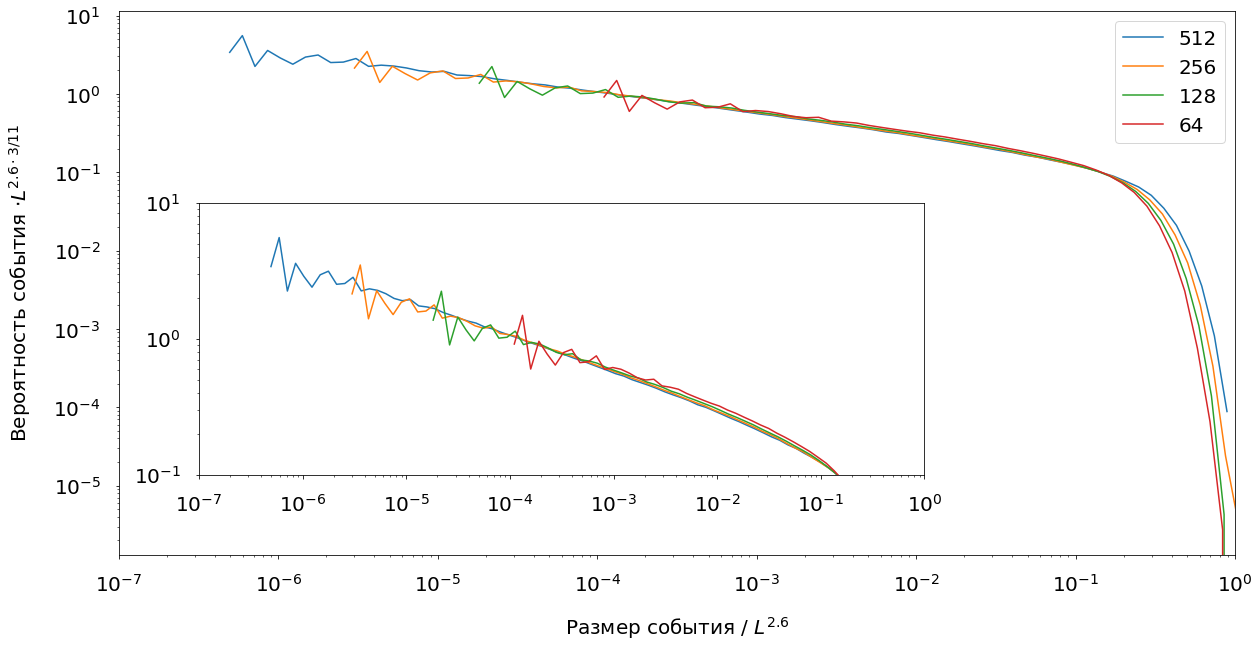

In [7]:
gamma = 2.6
plot_distribution(rand, gamma, False, 3./11, "3/11")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

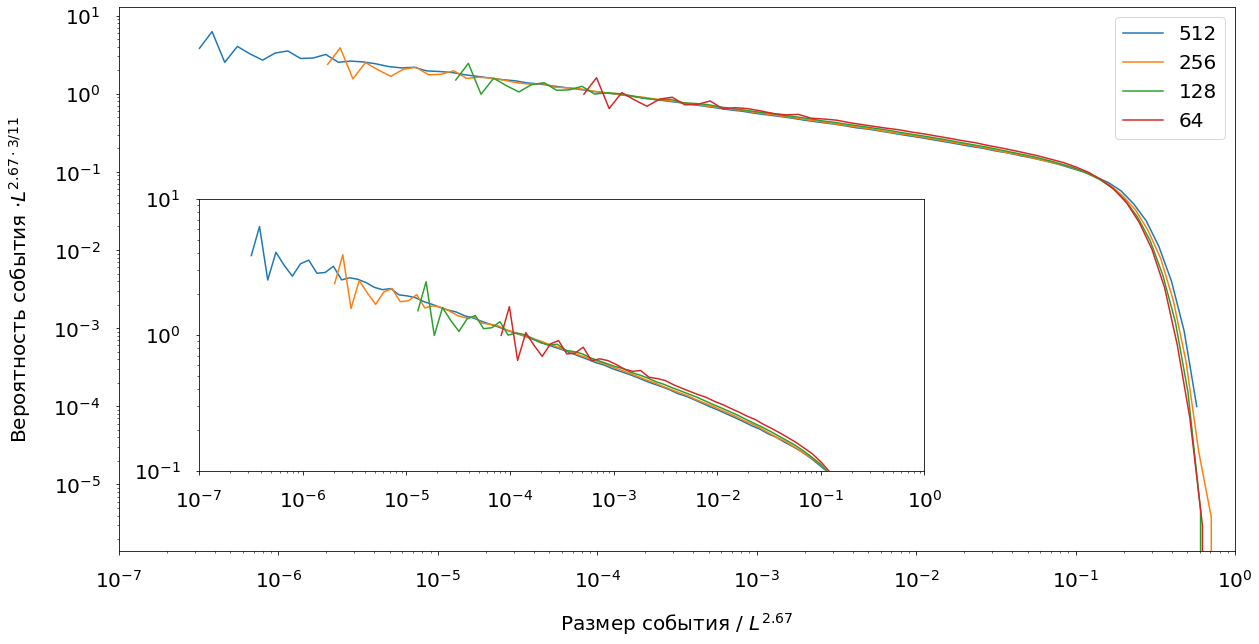

In [8]:
gamma = 2.67
plot_distribution(rand, gamma, False, 3./11, "3/11")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

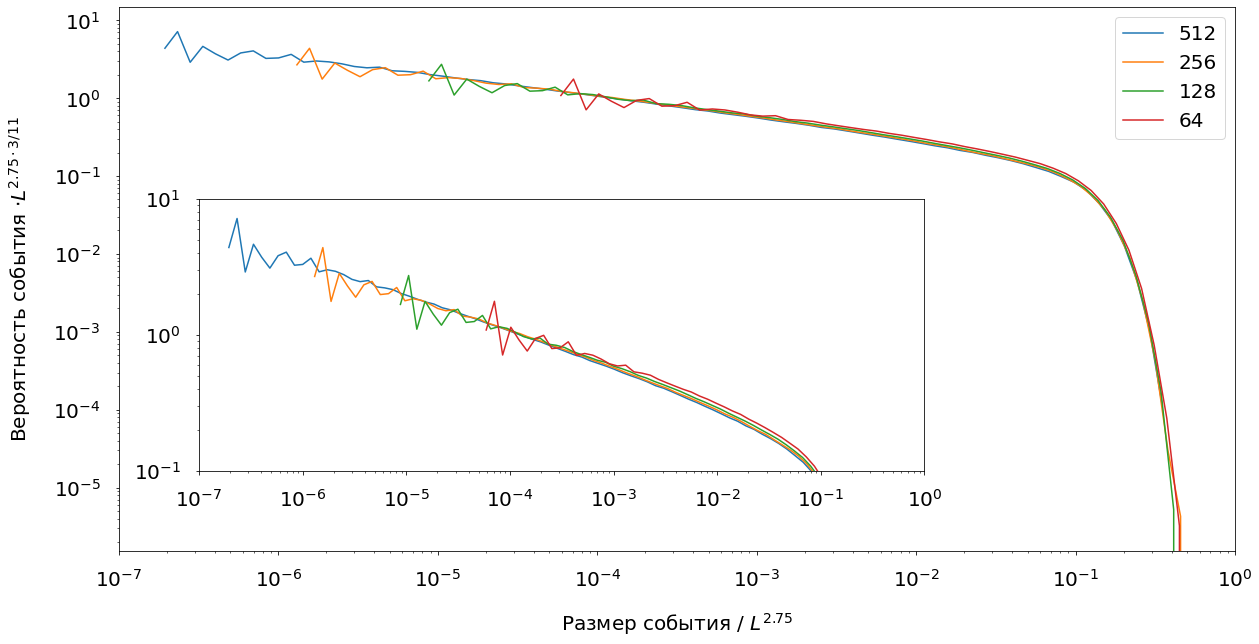

In [9]:
gamma = 2.75
plot_distribution(rand, gamma, False, 3./11, "3/11")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

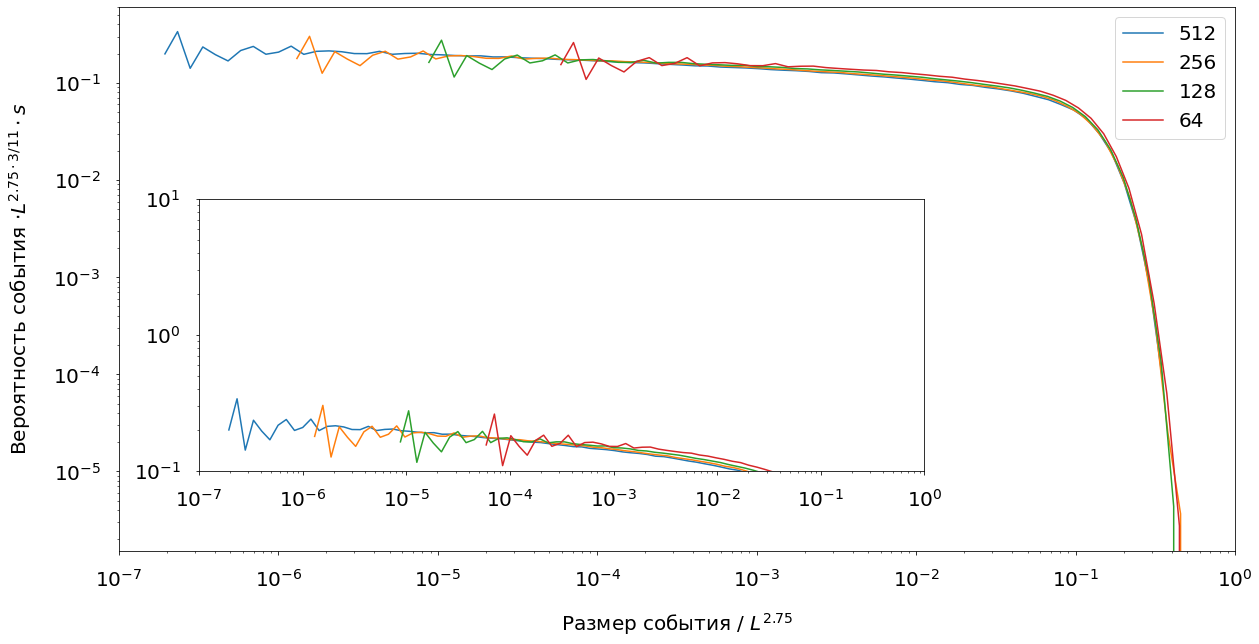

In [23]:
gamma = 2.75
plot_distribution_ysacle2(rand, gamma, False, 3./11, 0.2, "3/11")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

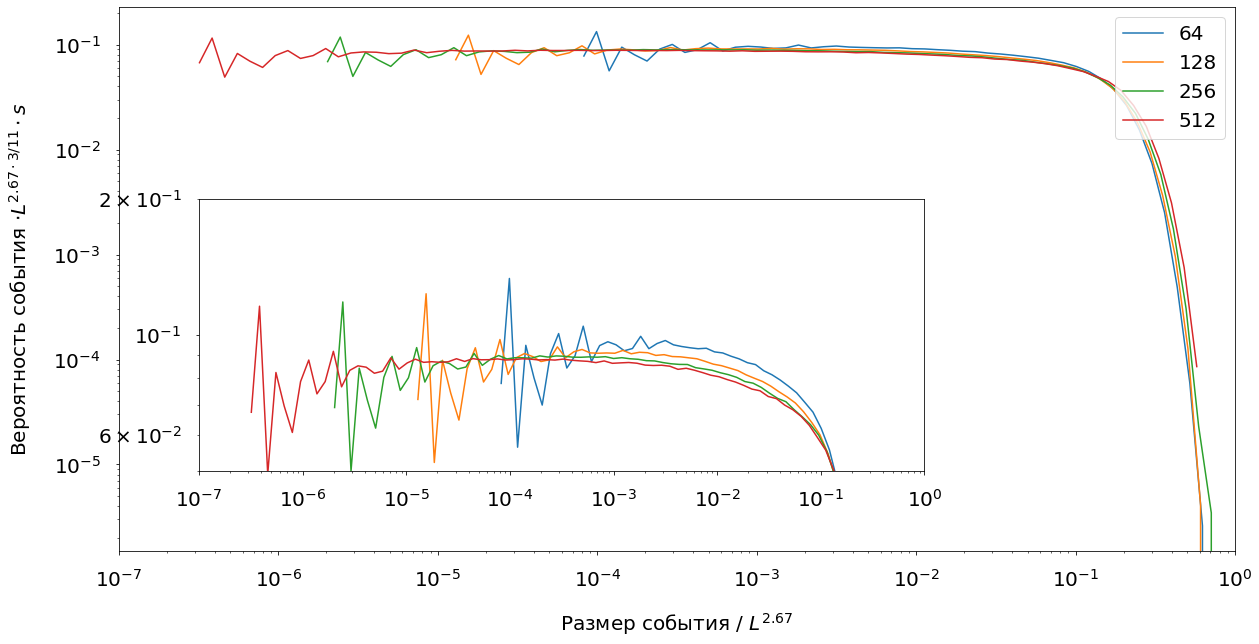

In [30]:
gamma = 2.67
plot_distribution_ysacle2(rand, gamma, False, 3./11, 0.27, "3/11", innerylim=[5e-2, 0.2])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

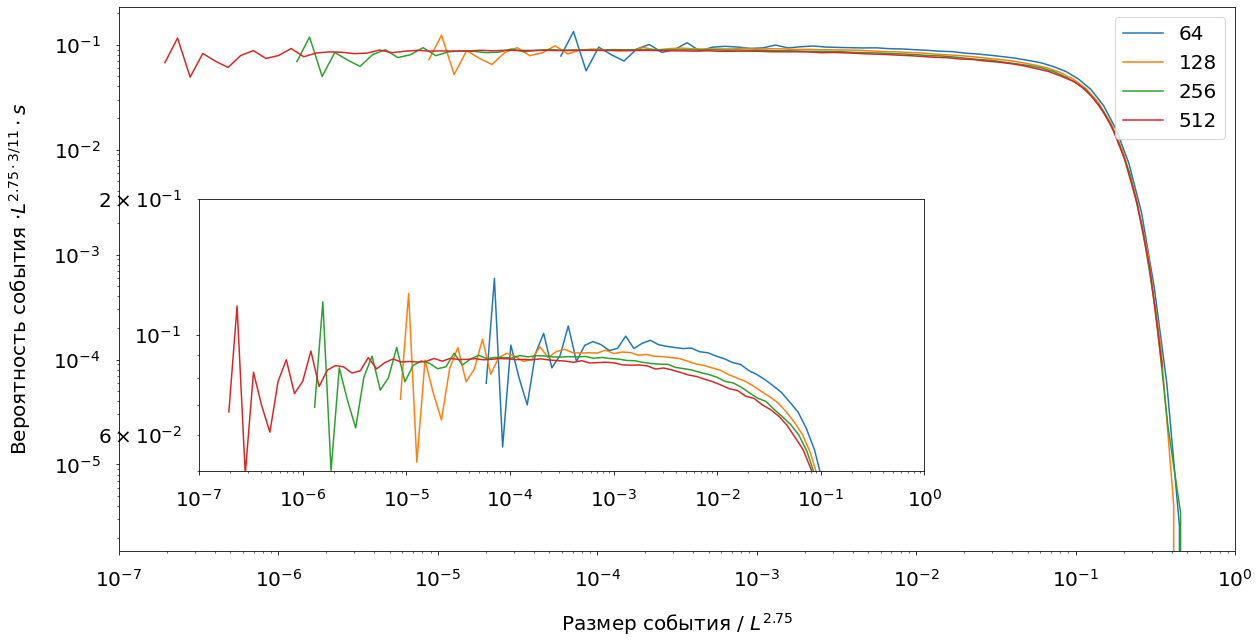

In [31]:
gamma = 2.75
plot_distribution_ysacle2(rand, gamma, False, 3./11, 0.27, "3/11", innerylim=[5e-2, 0.2])

# BTW model

0it [00:00, ?it/s]

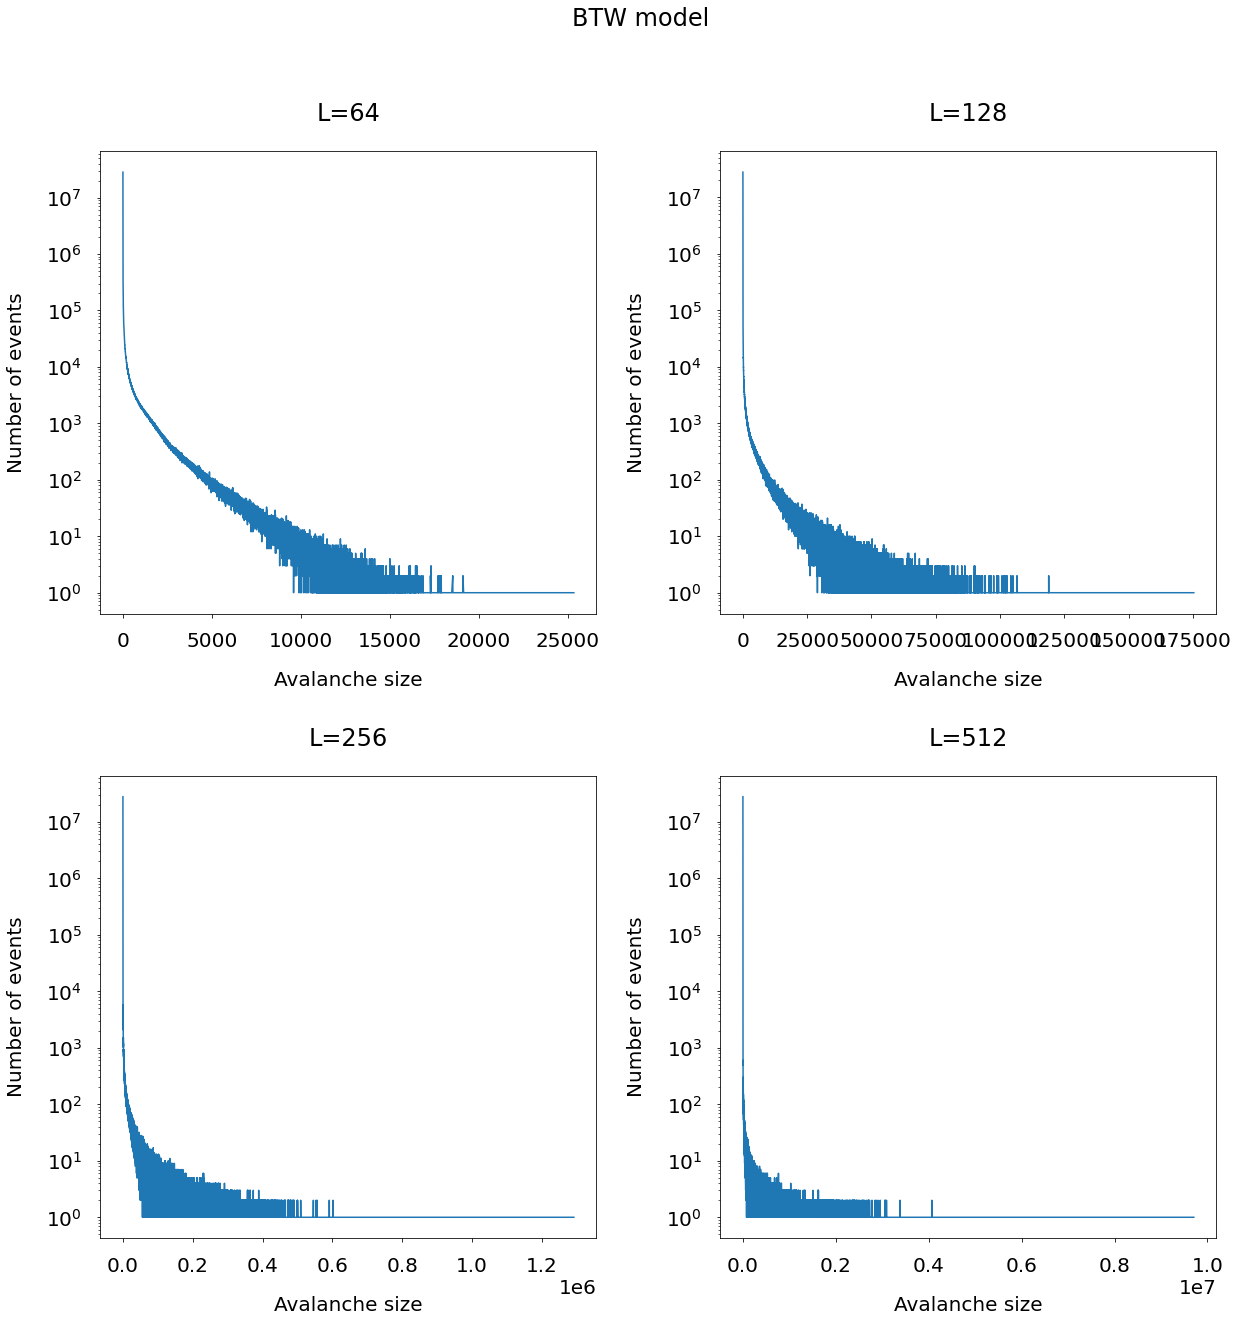

In [10]:
determ = {}

fig, _ = plt.subplots(2,2,figsize=(20,20))
fig.subplots_adjust(hspace=0.35, wspace=0.25)

for i, L in tqdm(enumerate([64, 128, 256, 512])):
    with open(f'../data/distribution/train_{L}_determ.out') as f:
        plt.subplot(2, 2, i+1)
        determ[L] = {}
        for line in f:
            size, count = list(map(int, line.split()))
            determ[L][size] = count
        plt.plot(determ[L].keys(), determ[L].values(), label=L)
        plt.yscale("log")
        #plt.legend()
        plt.xlabel("Avalanche size")
        plt.ylabel("Number of events")
        plt.title(f"L={L}")

plt.suptitle("BTW model")

plt.show()

0it [00:00, ?it/s]

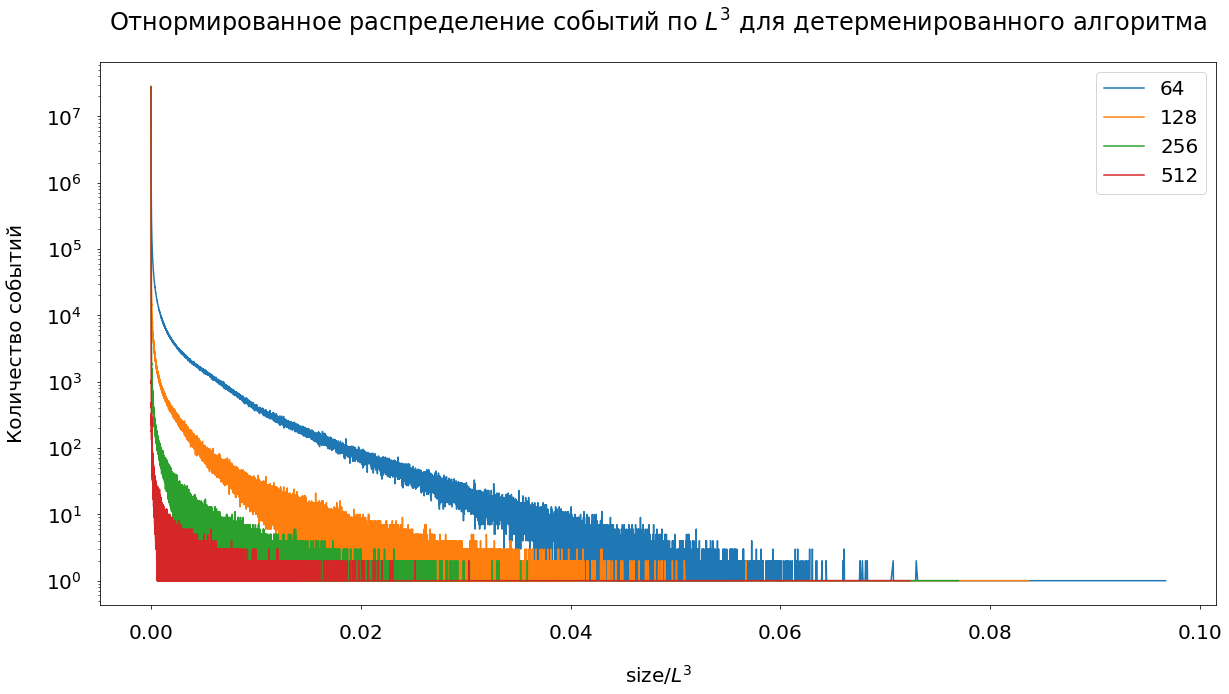

In [11]:
for i, L in tqdm(enumerate([64, 128, 256, 512])):
    sizes = np.array(list(determ[L].keys()))
    plt.plot(sizes / L**3, determ[L].values(), label=L)
plt.title("Отнормированное распределение событий по $L^{3}$ для детерменированного алгоритма")
plt.yscale("log")
#plt.xscale("log")
plt.legend()
plt.xlabel("size/$L^3$")
plt.ylabel("Количество событий")
plt.show()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

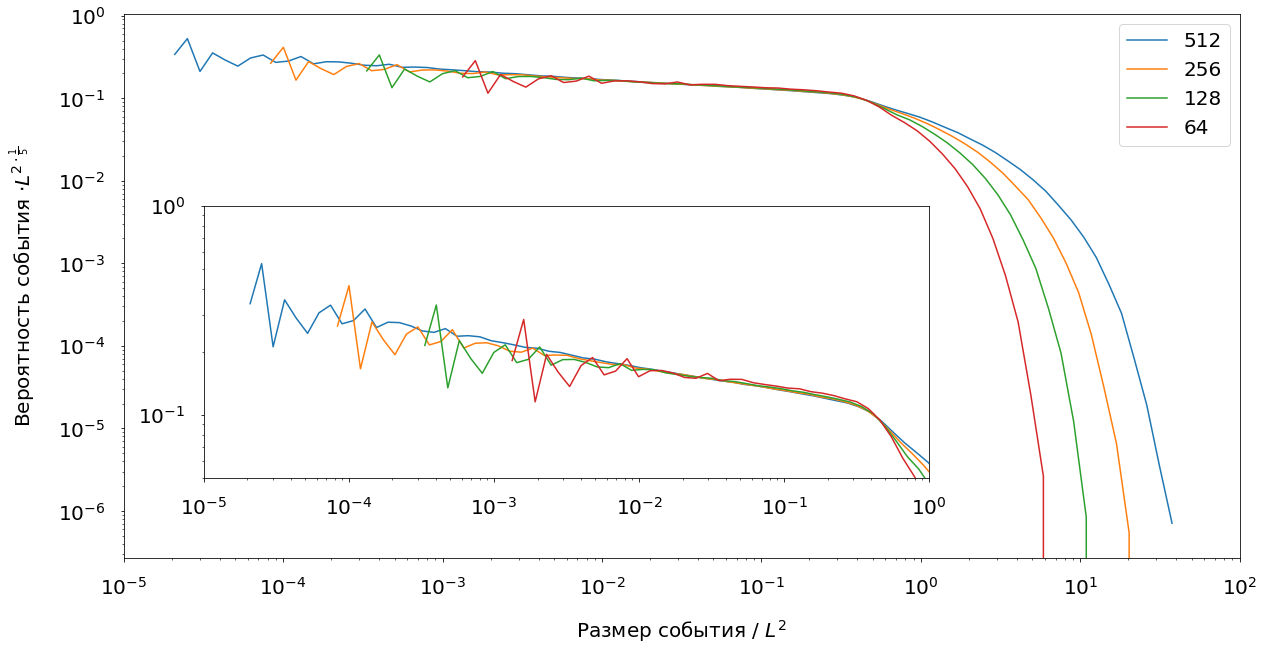

In [12]:
plot_distribution(determ, 2, False, 0.2, r"\frac{1}{5}", xlim=[1e-5, 1e+2], innerxlim=[1e-5, 1e+0], innerylim=[5e-2,1e+0])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

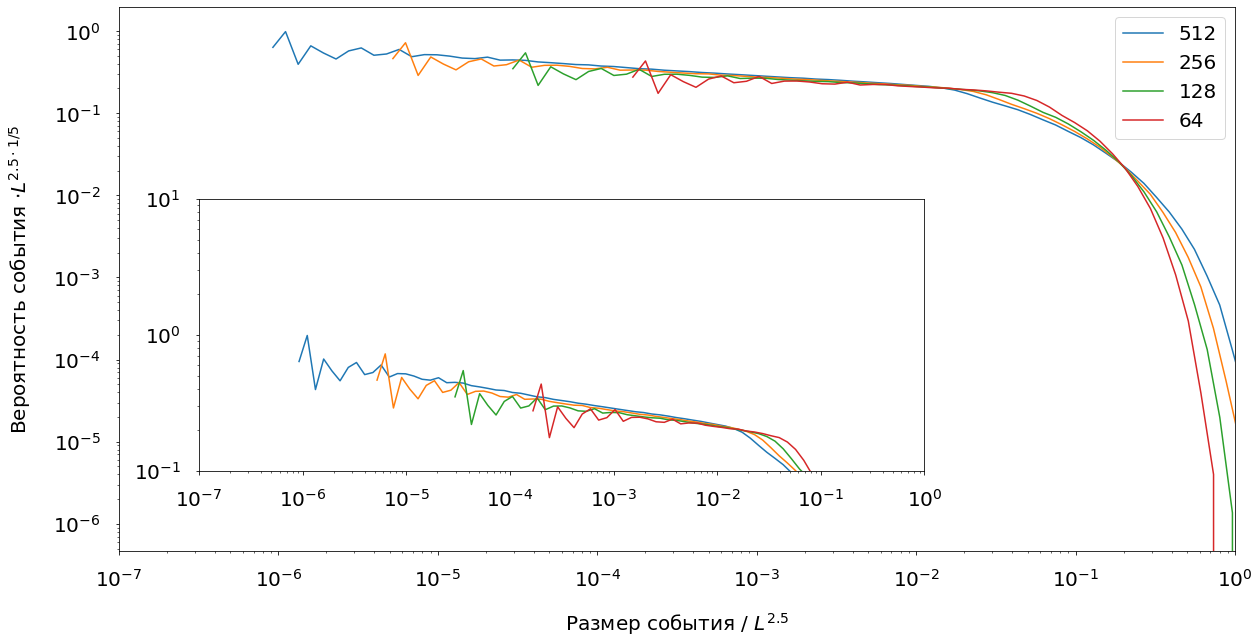

In [13]:
plot_distribution(determ, 2.5, False, 0.2, "1/5")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

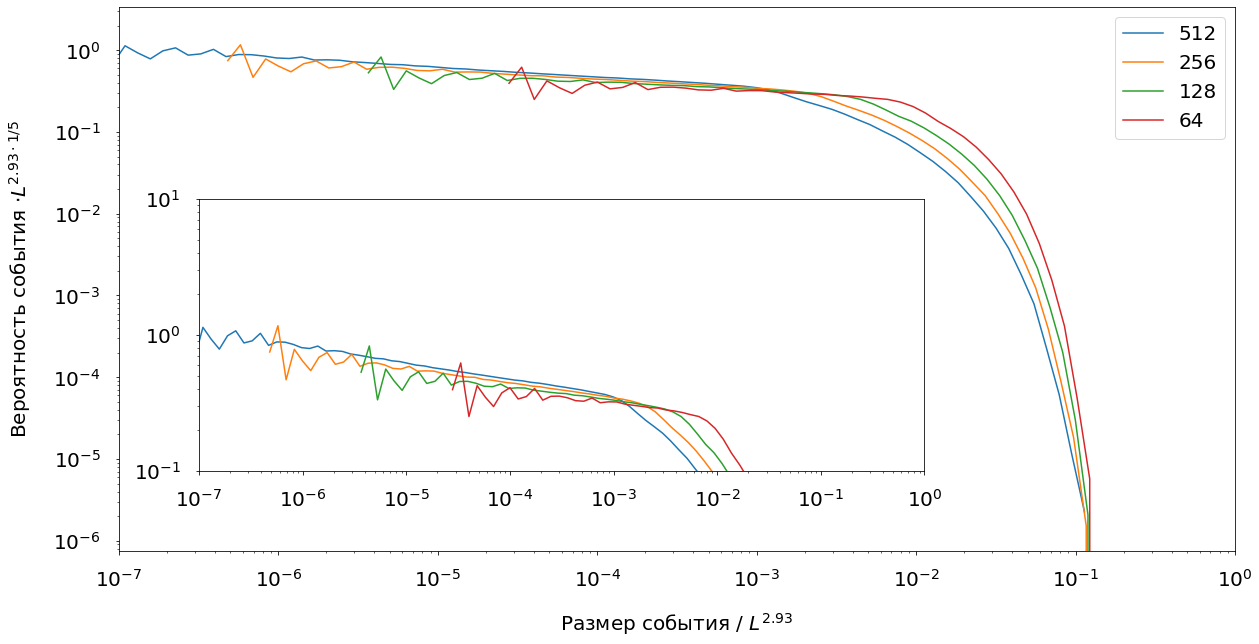

In [14]:
plot_distribution(determ, 2.93, False, 0.2, "1/5")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

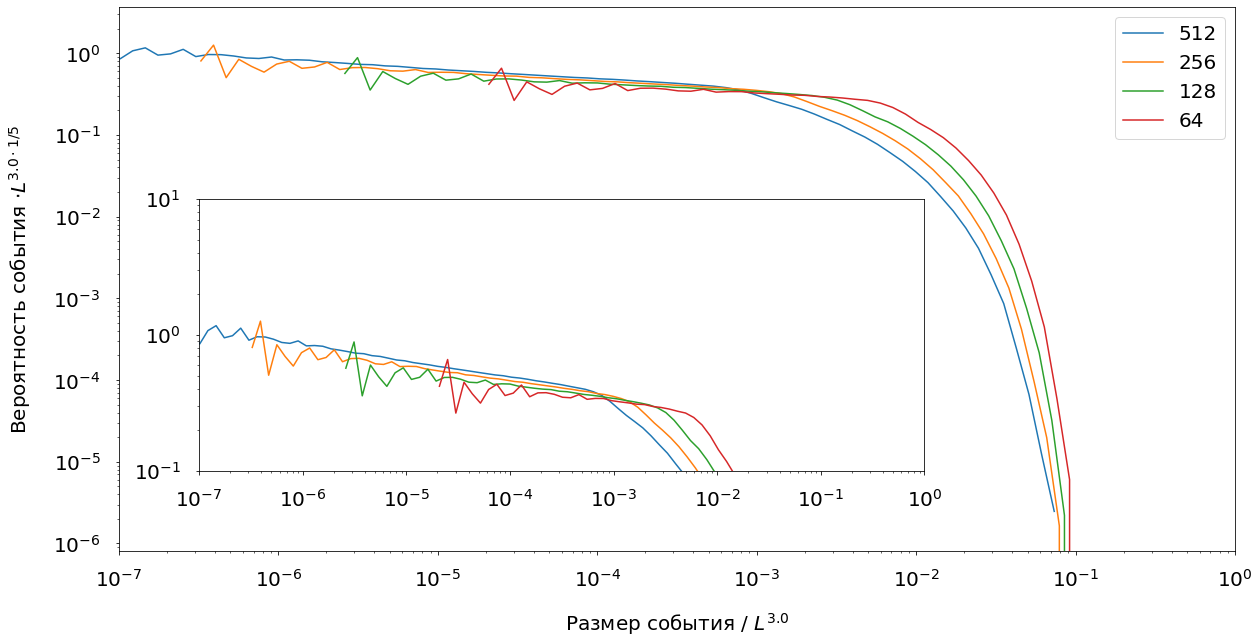

In [15]:
plot_distribution(determ, 3.0, False, 0.2, "1/5")

# Largest events in BTW model

In [16]:
lattice_sizes = []
largest_events = []

for L, sizes in rand.items():
    x = [(size, count) for (size, count) in sizes.items() if count > 0]
    x = sorted(x, key=lambda x: x[0])
    lattice_sizes.append(L)
    largest_events.append(x[-1][0])

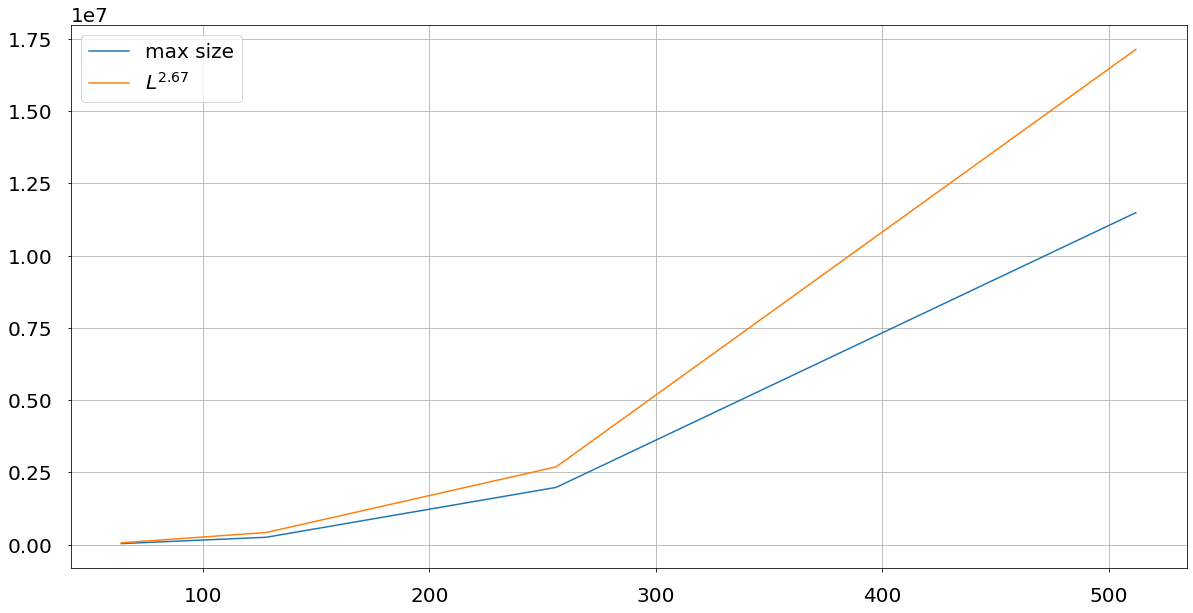

In [17]:
plt.plot(lattice_sizes, largest_events, label='max size')
plt.plot(lattice_sizes, [L**2.67 for L in lattice_sizes], label='$L^{2.67}$')
plt.legend()
plt.grid()
plt.show()

In [18]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

In [19]:
lattice_sizes = []
largest_events = []

for L, sizes in rand.items():
    x = [(size, count) for (size, count) in sizes.items() if count > 0]
    x = sorted(x, key=lambda x: x[0])
    lattice_sizes.append(L)
    largest_events.append(x[-1][0])
    
l267 = [L**2.67 for L in lattice_sizes]
l275 = [L**2.75 for L in lattice_sizes]

lattice_sizes = np.array([[L] for L in lattice_sizes])
largest_events = np.array(largest_events)
l267 = np.array(l267)
l275 = np.array(l275)

linreg = LinearRegression()
linreg = linreg.fit(np.log(lattice_sizes), np.log(largest_events))
print("linear coef of largest_events = " + f"{linreg.coef_[0]}")

linreg = LinearRegression()
linreg = linreg.fit(np.log(lattice_sizes), np.log(l267))
print("linear coef of $L^{2.67}$ = " + f"{linreg.coef_[0]}")

linreg = LinearRegression()
linreg = linreg.fit(np.log(lattice_sizes), np.log(l275))
print("linear coef of $L^{2.75}$ = " + f"{linreg.coef_[0]}")

# plt.plot(lattice_sizes, largest_events, label=f'max size {id_max}')
# plt.plot(lattice_sizes, [L**2.67 for L in lattice_sizes], label='$L^{2.63}$')
# plt.plot(lattice_sizes, [L**2.75 for L in lattice_sizes], label='$L^{2.75}$')

linear coef of largest_events = 2.7499272171830436
linear coef of $L^{2.67}$ = 2.6699999999999995
linear coef of $L^{2.75}$ = 2.7499999999999996


In [45]:
def plot_max_elem(id_max):
    lattice_sizes = []
    largest_events = []

    for L, sizes in rand.items():
        x = [(size, count) for (size, count) in sizes.items() if count > 0]
        x = sorted(x, key=lambda x: x[0])
        lattice_sizes.append(L)
        largest_events.append(x[id_max][0])
        
    plt.plot(lattice_sizes, largest_events, label=f'max size {id_max}')
    plt.plot(lattice_sizes, [L**2.67 for L in lattice_sizes], label='$L^{2.63}$')
    plt.plot(lattice_sizes, [L**2.75 for L in lattice_sizes], label='$L^{2.75}$')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.show()

In [74]:
def coef_max_elem(id_max):
    lattice_sizes = []
    largest_events = []

    for L, sizes in rand.items():
        x = [(size, count) for (size, count) in sizes.items() if count > 0]
        x = sorted(x, key=lambda x: x[0])
        lattice_sizes.append(L)
        largest_events.append(x[id_max][0])

    l267 = [L**2.67 for L in lattice_sizes]
    l275 = [L**2.75 for L in lattice_sizes]

    lattice_sizes = np.array([[L] for L in lattice_sizes])
    largest_events = np.array(largest_events)
    l267 = np.array(l267)
    l275 = np.array(l275)
    
    print("id max =", id_max)
    linreg = LinearRegression()
    linreg = linreg.fit(np.log(lattice_sizes), np.log(largest_events))
    print("linear coef of largest_events = " + f"{linreg.coef_[0]:.4}")

    linreg = LinearRegression()
    linreg = linreg.fit(np.log(lattice_sizes), np.log(l267))
    print("linear coef of $L^{2.67}$ = " + f"{linreg.coef_[0]:.4}")

    linreg = LinearRegression()
    linreg = linreg.fit(np.log(lattice_sizes), np.log(l275))
    print("linear coef of $L^{2.75}$ = " + f"{linreg.coef_[0]:.4}")

In [75]:
coef_max_elem(-1)

id max = -1
linear coef of largest_events = 2.75
linear coef of $L^{2.67}$ = 2.67
linear coef of $L^{2.75}$ = 2.75


In [76]:
coef_max_elem(-2)

id max = -2
linear coef of largest_events = 2.688
linear coef of $L^{2.67}$ = 2.67
linear coef of $L^{2.75}$ = 2.75


In [77]:
coef_max_elem(-3)

id max = -3
linear coef of largest_events = 2.695
linear coef of $L^{2.67}$ = 2.67
linear coef of $L^{2.75}$ = 2.75


In [78]:
coef_max_elem(-4)

id max = -4
linear coef of largest_events = 2.692
linear coef of $L^{2.67}$ = 2.67
linear coef of $L^{2.75}$ = 2.75


In [79]:
coef_max_elem(-5)

id max = -5
linear coef of largest_events = 2.696
linear coef of $L^{2.67}$ = 2.67
linear coef of $L^{2.75}$ = 2.75


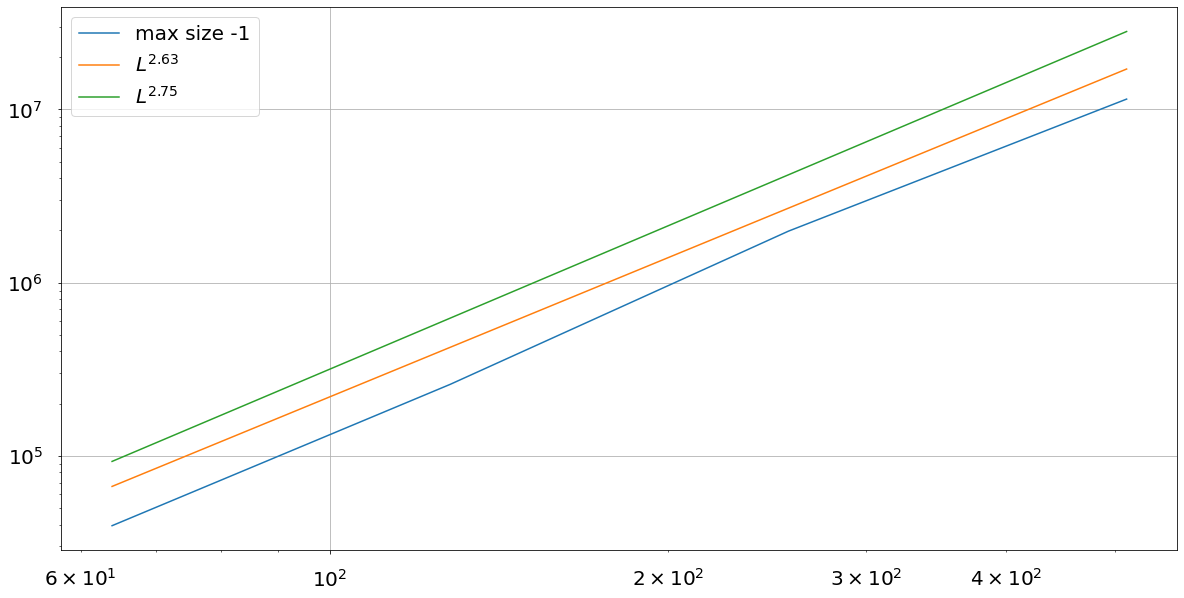

In [46]:
plot_max_elem(-1)

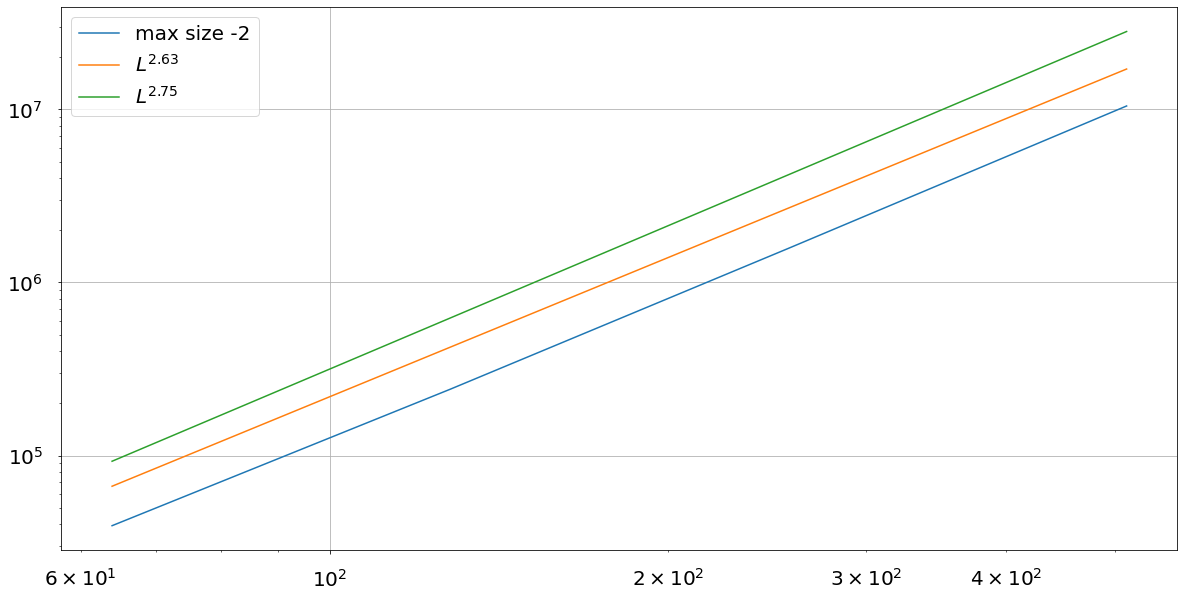

In [47]:
plot_max_elem(-2)

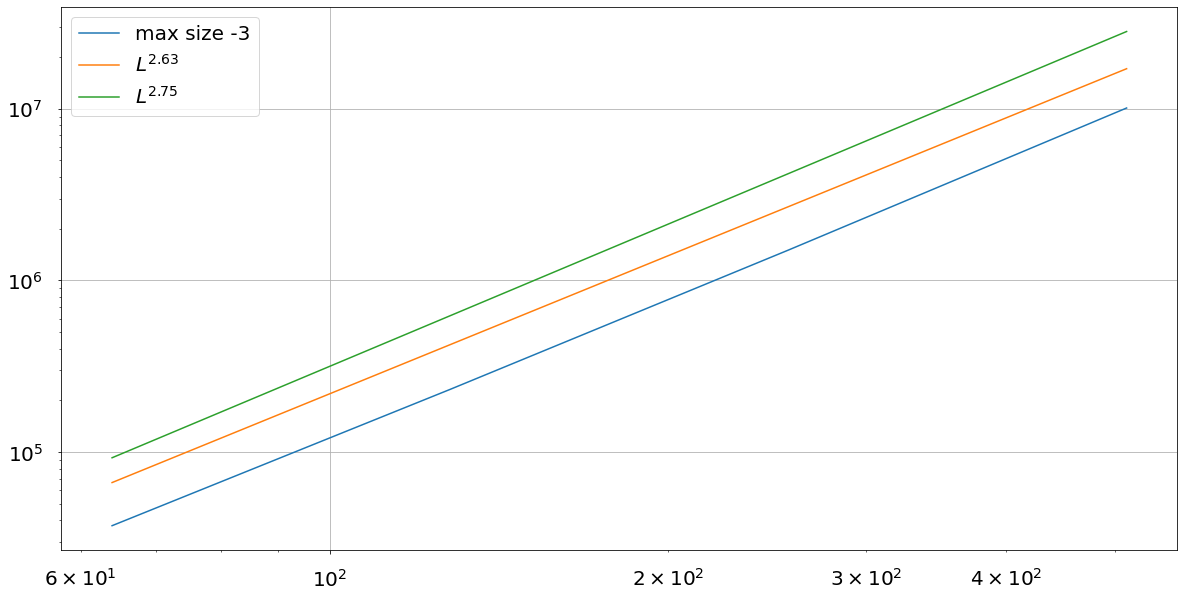

In [48]:
plot_max_elem(-3)

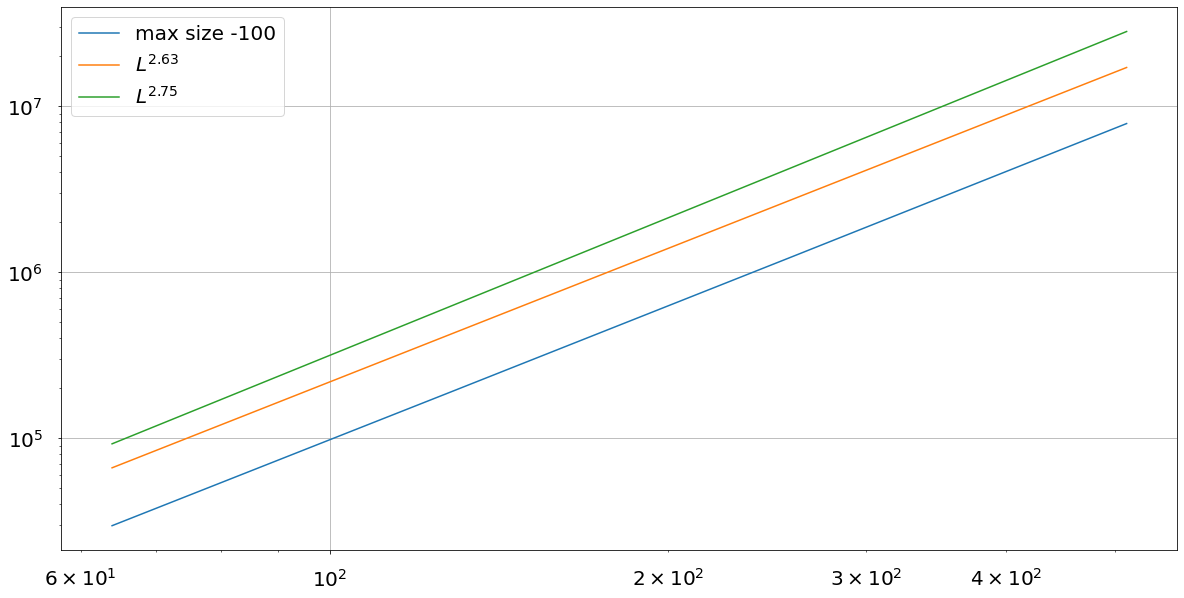

In [49]:
plot_max_elem(-100)

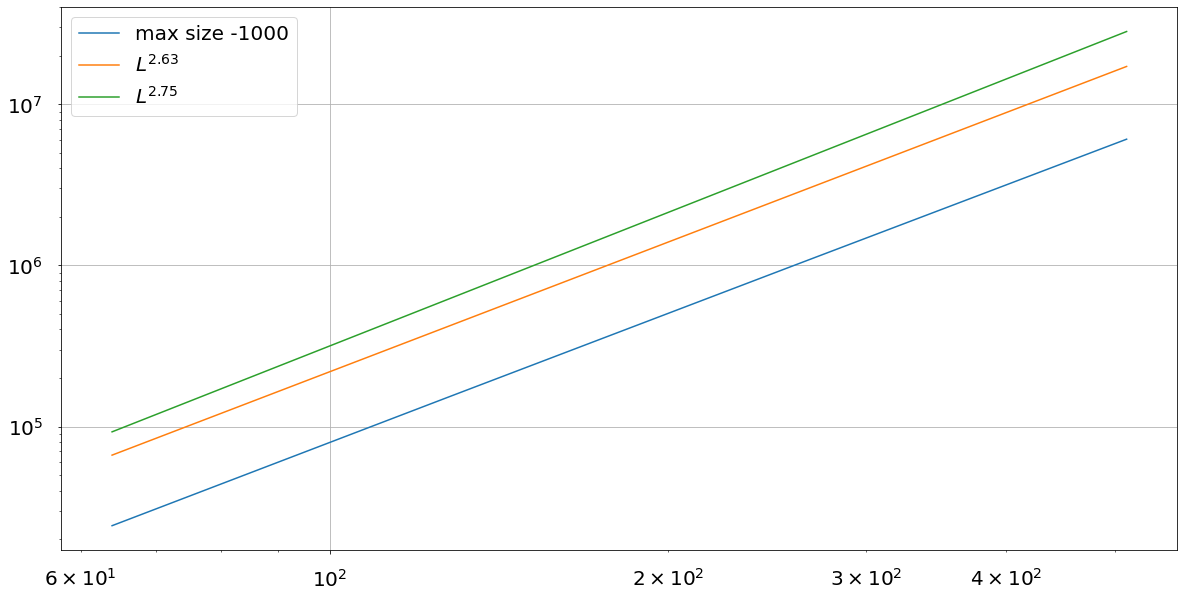

In [50]:
plot_max_elem(-1000)

# New type of plots

In [3]:
from spile import sfr_exact, sfr_av

def compute_ab_pdfs(model: str):
    for size in tqdm([64, 128, 256, 512]):
        gap = 1.2 #the bins are (s / gap, s * gap)
        pdfav_name = f'pdf_av_gap{gap}_train_{size}_{model}.txt'
        pdf_name = f'pdf_train_{size}_{model}.txt'
        
        iname = f'../data/train_{size}_{model}.out'
        
        smax = 1e+8 #maximal considered size
        s_bound_l = 10 #size border between the exact function and its approximation
        s_bound_r = 100 #exact pdf extends to this size in a weak color as a background of approximation

        #---Approximation
        #recommended to compute the approximation once and save it choosing issave=1
        #oname=<name> changes the default output name
        #the code does not verify the existence of folders; this the responsibility of a user
        #the output file consists of two columns: size and the estimate of the pdf
        s, freq, t_lng, q, s_out_of_arr = sfr_av(iname, smax, issave=1, oname=pdfav_name, gap=gap)
        #the output variables:
        #s - size, freq - pdf-function, t_lng - time difference between the last and first records, 
        #q - frequences (without normalization), s_out_of_arr - the number of avalanches with size > smax
        #These variables are ignored here and s and freq will be reloaded from the file
        #---Computed and saved

        #---Exact empirical pdf
        #input file <iname> (float)time (float)size anything
        #Assumed that size is integer (but can be written in a float format);
        #only size < smax are used in the construction
        #oname = <oname> makes the function write the output to the specified file
        #the output file consists of two columns: size and pdf
        s_exact, freq_exact, t_lng = sfr_exact(iname, smax=1000, oname=pdf_name)
        #---Computed and saved

In [4]:
compute_ab_pdfs('rand')

  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
#size-frequency relation
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect
from io2arr import file2twoarr #my function that reads two column files

def plot_ab_pdfs(model: str):
    linestyles = ["-o", "--x", ":s", "-.+"]
    sizes = [64, 128, 256, 512]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
    rc_fonts = { #include TeX (optional)
        #'font.size': 8,
        "text.usetex": True,
        'mathtext.default': 'regular',
        "text.latex.preamble": r"\usepackage{bm,amssymb,amsmath}",
        "figure.dpi": 200
    }
    plt.rcParams.update(rc_fonts)
        
    for size, l in zip(sizes, linestyles):
        gap = 1.2 #the bins are (s / gap, s * gap)
        pdfav_name = f'pdf_av_gap{gap}_train_{size}_{model}.txt'
        pdf_name = f'pdf_train_{size}_{model}.txt'
        
        # best values of s_bound_l and s_bound_r depend on the value of gap from the previous cell
        s_bound_l = 35 #border between the exact function and its approximation
        s_bound_r = 50 #exact pdf extends to this value in a weak color
        s_exact, freq_exact = file2twoarr(pdf_name) #reads exact pdf from file
        s, freq = file2twoarr(pdfav_name) #reads the estimate of pdf from file

        clr = 'blue' #color for the graph
        #define index borders for the graphs
        i_exact_1 = bisect(s_exact, s_bound_l)
        i_exact_2 = bisect(s_exact, s_bound_r)
        i_l = bisect(s, s_bound_l)
        ax.plot(s_exact[:i_exact_1+1], freq_exact[:i_exact_1+1], label=f'$f$ {size}', color=clr, linestyle='--')
        ax.plot(s_exact[i_exact_1:i_exact_2], freq_exact[i_exact_1:i_exact_2], 
                color=clr, alpha=0.5)
        ax.plot(s[i_l:], freq[i_l:], l, label=r'$\hat{{f}}$' + f" {size}", color='red', markersize=3)
    
    txt=r'$\hat{f}(s)=\frac{\mathsf{Prob}\{s/\Delta s < \mathtt{size} < s\Delta s\}}{s(\Delta s-1/\Delta s)}$'
    ax.text(0.5, 0.9, txt, 
            transform = ax.transAxes, horizontalalignment='left')
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('size, $s$')
    ax.set_ylabel(r'$\mathtt{pdf} f$ and its approximation $\hat{f}$')
    #plt.rcdefaults()  # restore the defaults changed with plt.rcParams.update()
        
    plt.show()

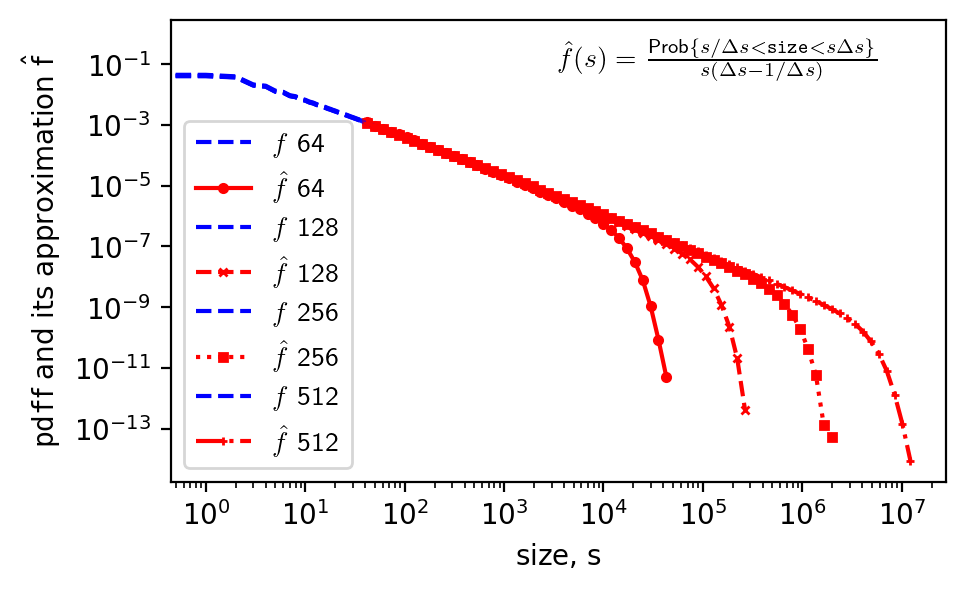

In [23]:
plot_ab_pdfs('rand')

In [5]:
#size-frequency relation

import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect
from io2arr import file2twoarr #my function that reads two column files

def plot_ab_mul_pdfs(model: str, gamma: float = 1.11, beta=None, tau=None, tau_str=None, ylim=(1e-2, 1e-1), xlim=(1, 5e+4)):
    sizes = [64, 128, 256, 512]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
    rc_fonts = { #include TeX (optional)
        #'font.size': 8,
        "text.usetex": True,
        'mathtext.default': 'regular',
        "text.latex.preamble": r"\usepackage{bm,amssymb,amsmath}",
    }
    plt.rcParams.update(rc_fonts)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    
    for lng, clr in zip(sizes, colors):
        gap = 1.2 #the bins are (s / gap, s * gap)
        pdfav_name = f'pdf_av_gap{gap}_train_{lng}_{model}.txt'
        pdf_name = f'pdf_train_{lng}_{model}.txt'
        
        s_bound_l = 20 #border between the exact function and its approximation
        s_bound_r = 40 #exact pdf extends to this value in a weak color
        s_exact, freq_exact = file2twoarr(pdf_name) #reads exact pdf from file
        s, freq = file2twoarr(pdfav_name) #reads the estimate of pdf from file

        #clr = 'blue' #color for the graph
        #define index borders for the graphs
        i_exact_1 = bisect(s_exact, s_bound_l)
        i_exact_2 = bisect(s_exact, s_bound_r)
        i_l = bisect(s, s_bound_l)
        
        x = np.array(s_exact[:i_exact_1+1])
        if beta is not None:
            x /= lng**beta
        y = np.array(freq_exact[:i_exact_1+1]) * x**gamma
        if beta is not None:
            y *= lng**(beta*tau)
            
        ax.plot(x, y, label=r'$L = {:d}$'.format(lng), color=clr)
        
        x = np.array(s_exact[i_exact_1:i_exact_2])
        if beta is not None:
            x /= lng**beta
        y = np.array(freq_exact[i_exact_1:i_exact_2]) * x**gamma
        if beta is not None:
            y *= lng**(beta*tau)
            
        ax.plot(x, y, color=clr, alpha=0.5)
        
        x = np.array(s[i_l:])
        if beta is not None:
            x /= lng**beta
        y = np.array(freq[i_l:]) * x**gamma
        if beta is not None:
            y *= lng**(beta*tau)
            
        ax.plot(x, y, color=clr)
        
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    if beta is None:
        xlabel = "size, $s$"
    else:
        xlabel = f'Normalised size, $b=s / L^{{{beta}}}$'
    if beta is None:
        gamma_txt = f'{gamma}'
        ylabel = '$\mathtt{{pdf}}(s) \cdot s^{{{:s}}}$'.format(gamma_txt)
    else:
        ylabel = f'$\mathtt{{pdf}}(s) \cdot s^{{{gamma}}} \cdot L^{{{beta} \cdot {tau_str}}}$'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.set_ylabel(r'$\mathtt{pdf}(s)\cdot s^{:s}$'.format(gamma_txt))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    #plt.rcdefaults()  # restore the defaults changed with plt.rcParams.update()

In [21]:
#size-frequency relation

import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect
from io2arr import file2twoarr #my function that reads two column files

def plot_ab_mul_pdfs_full(
    model: str,
    gamma: float = 1.11,
    beta=None,
    tau=None,
    tau_str=None,
    ylim=(1e-2, 1e-1),
    xlim=(1, 5e+4),
    internal_ax=None,
    legend_loc="best",
    legend_title="L"
):
    sizes = [64, 128, 256, 512]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
    rc_fonts = { #include TeX (optional)
        #'font.size': 8,
        "text.usetex": True,
        'mathtext.default': 'regular',
        "text.latex.preamble": r"\usepackage{bm,amssymb,amsmath}",
    }
    plt.rcParams.update(rc_fonts)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    
    axin = ax.inset_axes(internal_ax["position"]) if internal_ax is not None else None
    
    for lng, clr in zip(sizes, colors):
        gap = 1.2 #the bins are (s / gap, s * gap)
        pdfav_name = f'pdf_av_gap{gap}_train_{lng}_{model}.txt'
        pdf_name = f'pdf_train_{lng}_{model}.txt'
        
        s_bound_l = 20 #border between the exact function and its approximation
        s_bound_r = 40 #exact pdf extends to this value in a weak color
        s_exact, freq_exact = file2twoarr(pdf_name) #reads exact pdf from file
        s, freq = file2twoarr(pdfav_name) #reads the estimate of pdf from file

        #clr = 'blue' #color for the graph
        #define index borders for the graphs
        i_exact_1 = bisect(s_exact, s_bound_l)
        i_exact_2 = bisect(s_exact, s_bound_r)
        i_l = bisect(s, s_bound_l)
        
        x = np.array(s[i_l+5:])
        if beta is not None:
            x /= lng**beta
        y = np.array(freq[i_l+5:]) * x**gamma
        if beta is not None:
            y *= lng**(beta*tau)
            
        ax.plot(x, y, color=clr, label=lng)
        if axin is not None:
            axin.plot(x, y, color=clr)
    
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')       
    if beta is None:
        xlabel = "size, $s$"
    else:
        xlabel = f'Normalised size, $b=s / L^{{{beta}}}$'
    if beta is None:
        gamma_txt = f'{gamma}'
        ylabel = '$\mathtt{{pdf}}(s) \cdot s^{{{:s}}}$'.format(gamma_txt)
    else:
        ylabel = f'$\mathtt{{pdf}}(s) \cdot s^{{{gamma}}} \cdot L^{{{beta} \cdot {tau_str}}}$'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title, loc=legend_loc)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if axin is not None:
        axin.set_xscale('log')
        axin.set_yscale('log')
        axin.set_xlim(internal_ax["xlim"])
        axin.set_ylim(internal_ax["ylim"])
        if internal_ax.get("indicate_zoom", False):
            ax.indicate_inset_zoom(axin, edgecolor="black")
            
    plt.show()
    #plt.rcdefaults()  # restore the defaults changed with plt.rcParams.update()

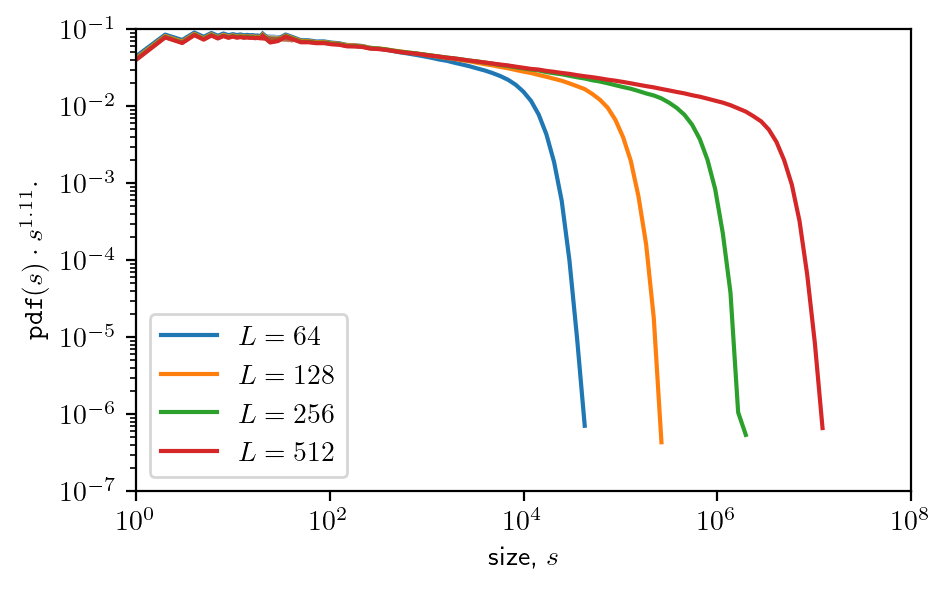

In [59]:
plot_ab_mul_pdfs("rand", ylim=(1e-7, 1e-1), xlim=(1, 10**8))

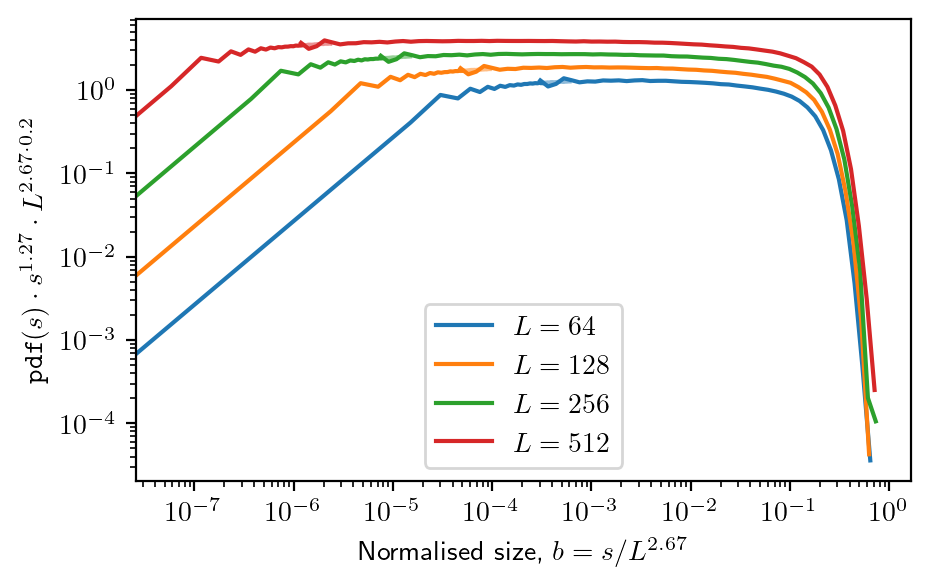

In [108]:
plot_ab_mul_pdfs("rand", gamma=1.27, beta=2.67, tau=0.2, tau_str=r"0.2", ylim=None, xlim=None)

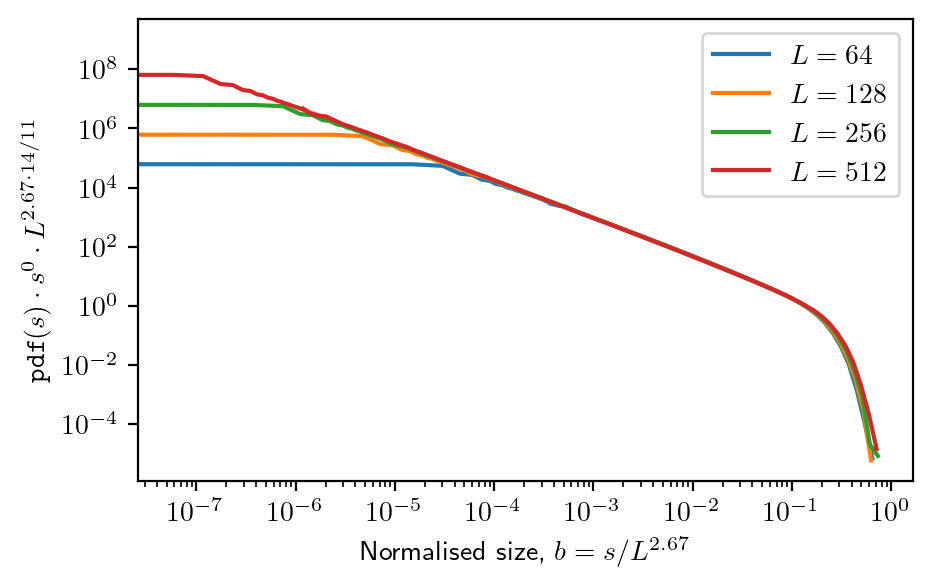

In [111]:
plot_ab_mul_pdfs("rand", gamma=0, beta=2.67, tau=14/11, tau_str=r"14/11", ylim=None, xlim=None)

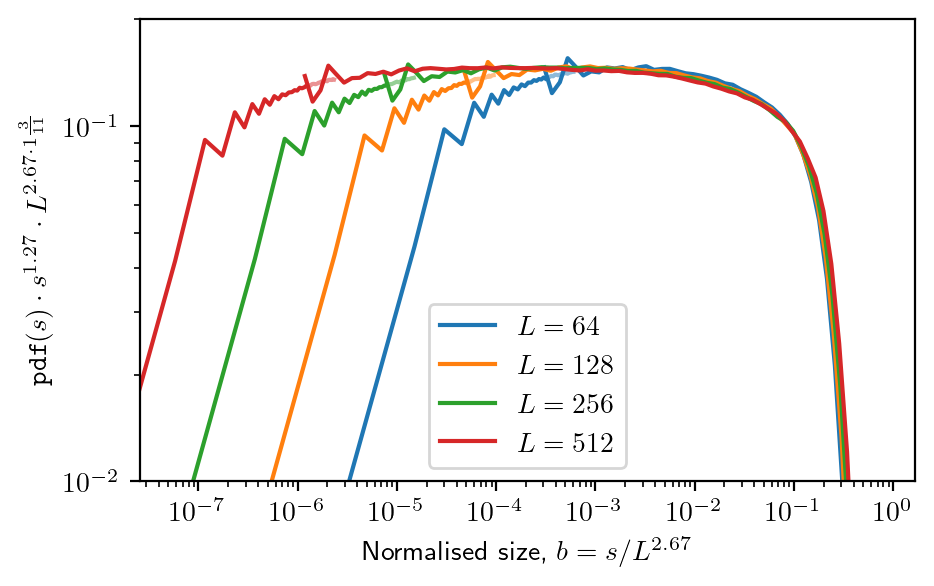

In [127]:
plot_ab_mul_pdfs("rand", gamma=1.27, beta=2.67, tau=14/11, tau_str=r"1\frac{3}{11}", ylim=(1e-2, 0.2), xlim=None)

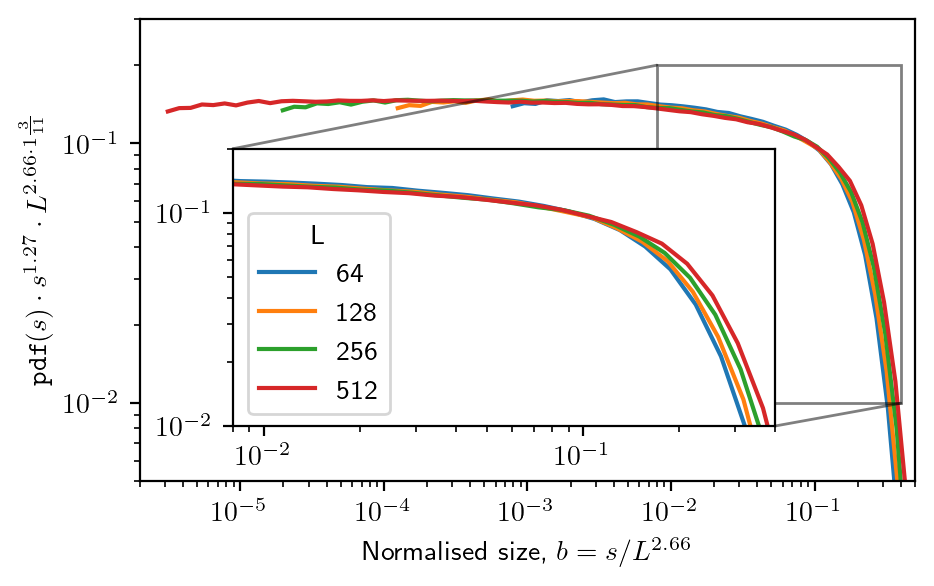

In [25]:
plot_ab_mul_pdfs_full(
    "rand",
    gamma=1.27,
    beta=2.66,
    tau=14/11,
    tau_str=r"1\frac{3}{11}",
    xlim=(2e-6, 5e-1),
    ylim=(5e-3, 0.3),
    internal_ax={
        "position": [0.12, 0.12, 0.7, 0.6],
        "xlim": (8e-3, 4e-1),
        "ylim": (1e-2, 0.2),
        "indicate_zoom": True
    },
    legend_loc=(0.14, 0.145),
    legend_title="L"
)

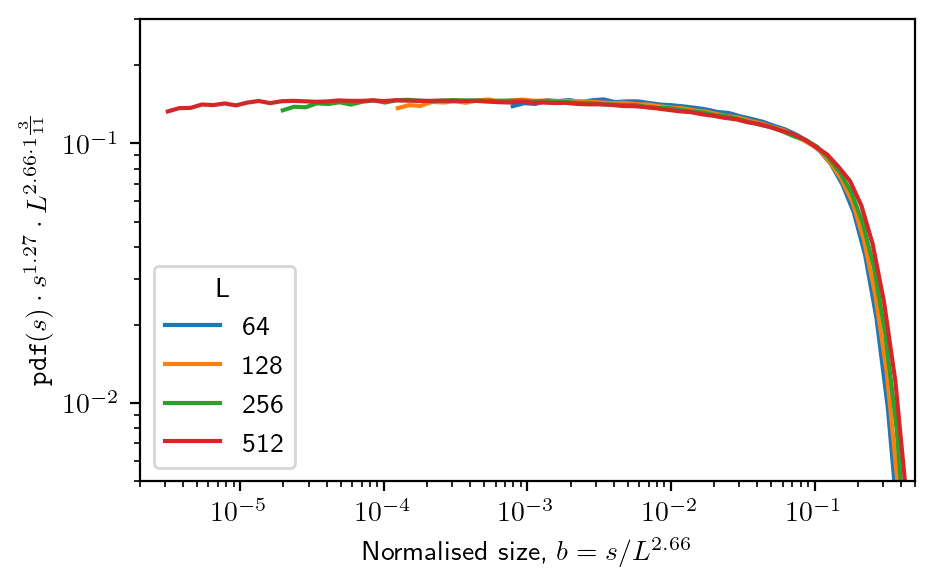

In [164]:
plot_ab_mul_pdfs_full(
    "rand",
    gamma=1.27,
    beta=2.66,
    tau=14/11,
    tau_str=r"1\frac{3}{11}",
    xlim=(2e-6, 5e-1),
    ylim=(5e-3, 0.3),
    internal_ax=None
)

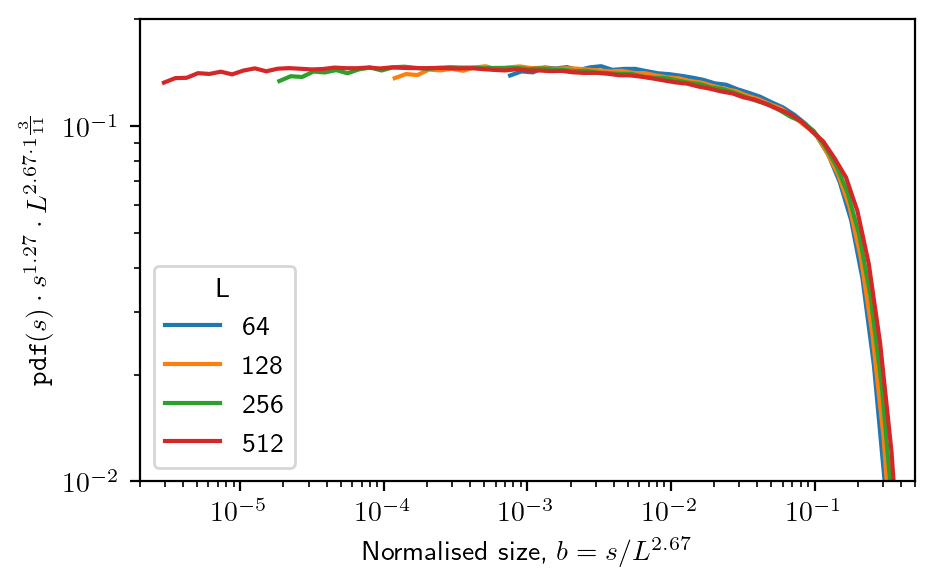

In [135]:
plot_ab_mul_pdfs_full("rand", gamma=1.27, beta=2.67, tau=14/11, tau_str=r"1\frac{3}{11}", ylim=(1e-2, 0.2), xlim=(2e-6, 5e-1))

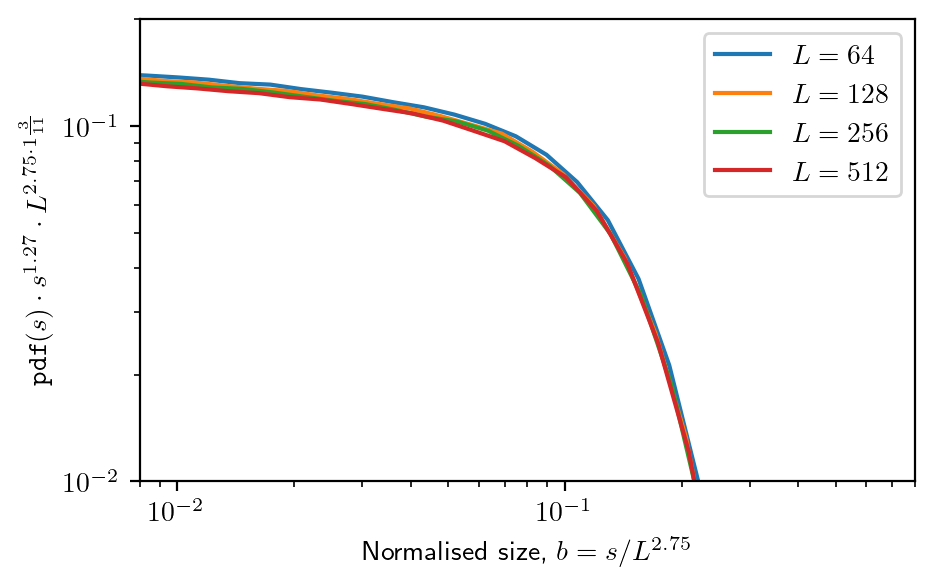

In [123]:
plot_ab_mul_pdfs("rand", gamma=1.27, beta=2.75, tau=14/11, tau_str=r"1\frac{3}{11}", ylim=(1e-2, 0.2), xlim=(8e-3, 8e-1))

  0%|          | 0/4 [00:00<?, ?it/s]

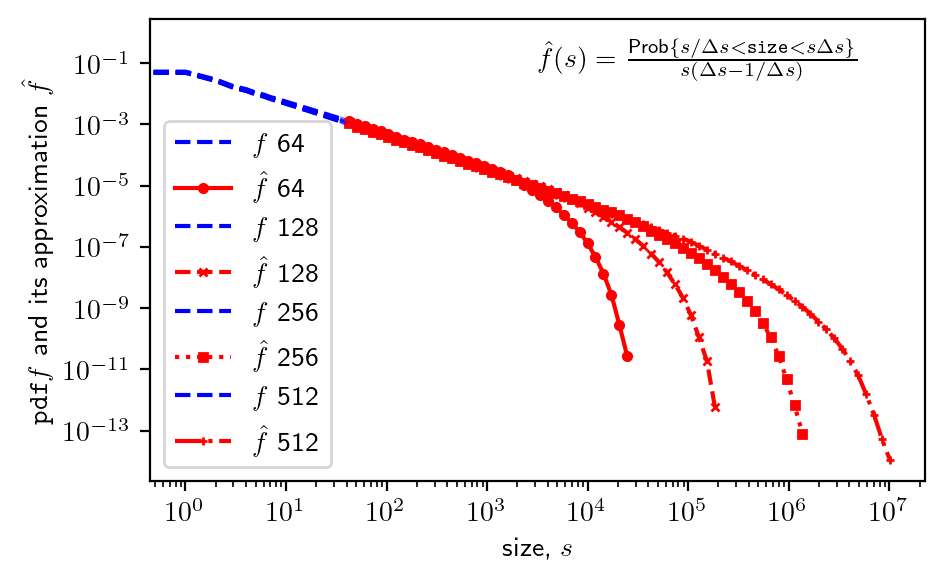

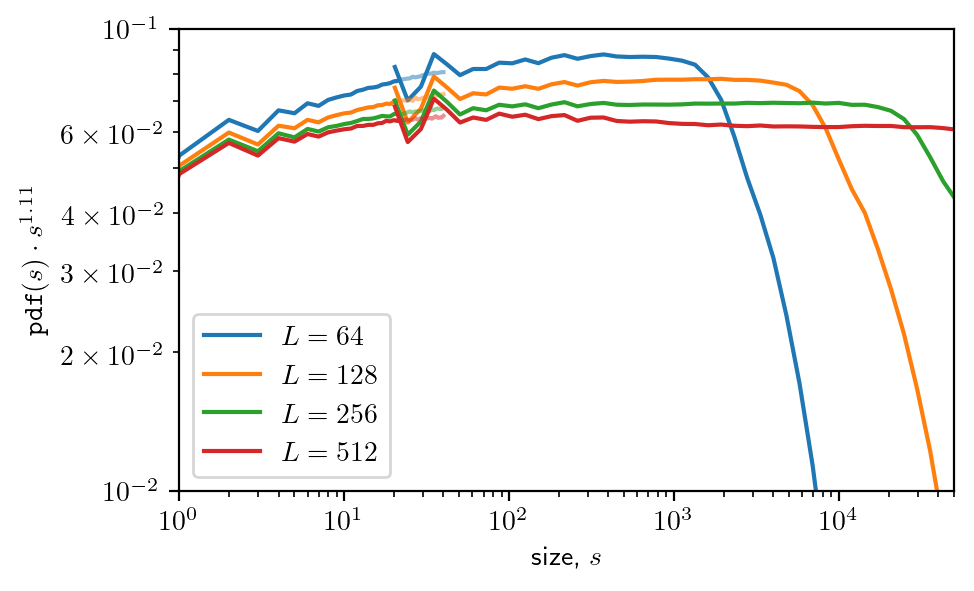

In [82]:
compute_ab_pdfs('determ')
plot_ab_pdfs('determ')
plot_ab_mul_pdfs('determ')

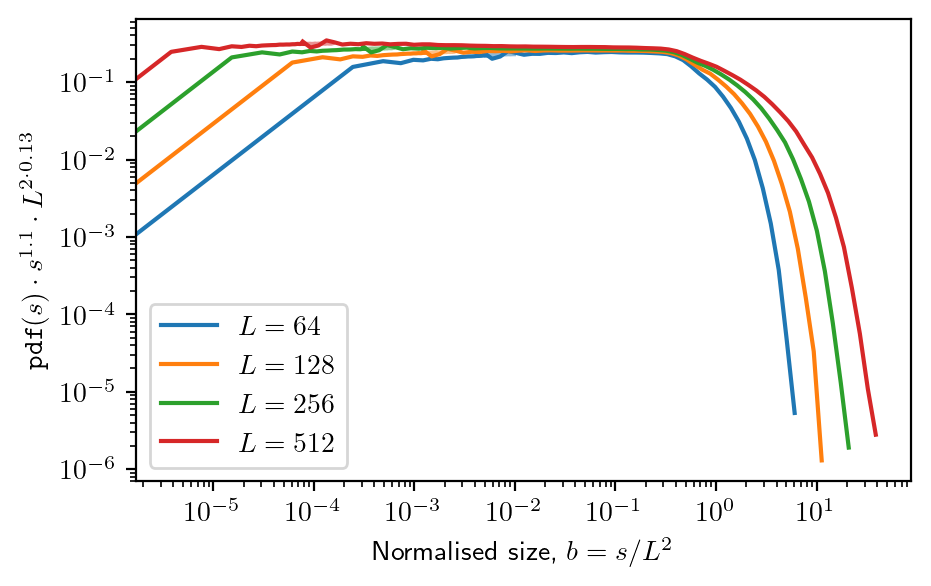

In [104]:
plot_ab_mul_pdfs('determ', gamma=1.1, beta=2, tau=0.13, tau_str=r"0.13", ylim=None, xlim=None)

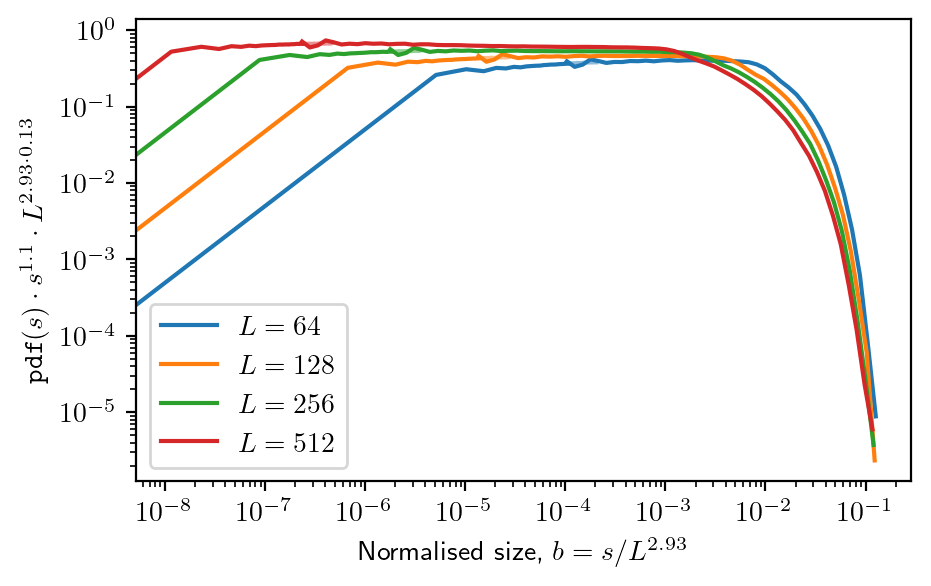

In [105]:
plot_ab_mul_pdfs('determ', gamma=1.1, beta=2.93, tau=0.13, tau_str=r"0.13", ylim=None, xlim=None)

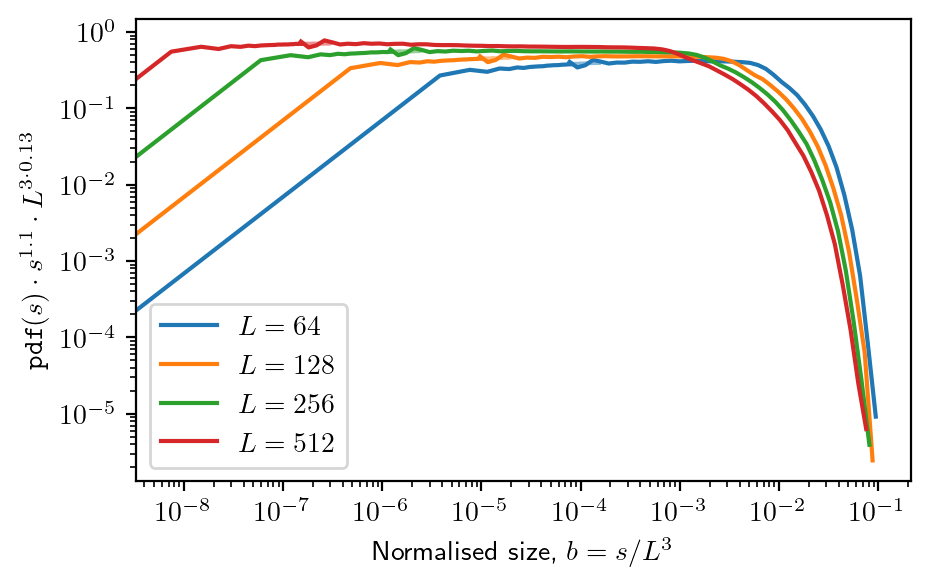

In [106]:
plot_ab_mul_pdfs('determ', gamma=1.1, beta=3, tau=0.13, tau_str=r"0.13", ylim=None, xlim=None)

In [ ]:
plot_ab_mul_pdfs('rand', gamma=1.1, beta=2.93, tau=0.13, tau_str=r"0.13", ylim=None, xlim=None)